In [1]:
import os
from dataclasses import dataclass

import torch
import torchaudio
import requests
import matplotlib
import matplotlib.pyplot as plt
import IPython
import torchaudio.functional as F

matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)
print(device)

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/root/miniconda3/envs/wav2vec/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


1.7.1
0.7.0a0+a853dff
cuda


In [8]:
import sys
sys.path.insert(0, '../../../wav2vec/w2v_inference/scripts/')
sys.path.insert(0, '../../../wav2vec/w2v_inference/DeepSpeech/decoders')

In [17]:
import pandas as pd
import soundfile as sf

In [10]:
from util.model import load_model

In [61]:
explicit_audio = pd.read_csv('/d0/lyrics/explicit_loaded_lyrics.csv')

In [12]:
ctc_model = load_model('/data_asr/mir/dali_singer_lyrics/manifest_7x_dali_singer/outputs_w2v_base_from_ls960/checkpoints/checkpoint_best.pt',
                       '/data_asr/mir/dali_singer_lyrics/manifest_7x_dali_singer/',
                       '../../../wav2vec/w2v_inference/config/pretraining/wav2vec2_base_librispeech.yaml',
                       '/data_asr/mir/dali_singer_lyrics/manifest_7x_dali_singer/outputs_w2v_base_from_ls960/config_finetune.yaml',
                       training_mode=False)
ctc_model.to(device)

Wav2VecCtc(
  (w2v_encoder): Wav2VecEncoder(
    (w2v_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (4): Sequen

In [29]:
waveform.unsqueeze(0)

tensor([[-1.2512e-03,  9.1553e-05, -1.5259e-04,  ..., -4.5776e-04,
         -5.7983e-04, -1.2207e-04]])

In [289]:
explicit_audio.iloc[40]

ytid                                                4Moca9nzvDM
audio_path    /data_nas/mirdata/explicit/vocals_demusc_16khz...
lyrics        don't you think that it's boring how people ta...
title                                              tennis court
artist                                                    lorde
Name: 40, dtype: object

In [310]:
explicit_audio.audio_path

0       /data_nas/mirdata/explicit/vocals_demusc_16khz...
1       /data_nas/mirdata/explicit/vocals_demusc_16khz...
2       /data_nas/mirdata/explicit/vocals_demusc_16khz...
3       /data_nas/mirdata/explicit/vocals_demusc_16khz...
4       /data_nas/mirdata/explicit/vocals_demusc_16khz...
                              ...                        
2344    /data_nas/mirdata/explicit/vocals_demusc_16khz...
2345    /data_nas/mirdata/explicit/vocals_demusc_16khz...
2346    /data_nas/mirdata/explicit/vocals_demusc_16khz...
2347    /data_nas/mirdata/explicit/vocals_demusc_16khz...
2348    /data_nas/mirdata/explicit/vocals_demusc_16khz...
Name: audio_path, Length: 2349, dtype: object

In [314]:
ytid = 'wuO4_P_8p-Q'
SPEECH_FILE = explicit_audio[explicit_audio.ytid==ytid].iloc[0].audio_path
transcript = explicit_audio[explicit_audio.ytid==ytid].iloc[0].lyrics
explicit_audio[explicit_audio.ytid==ytid].iloc[0]

ytid                                                wuO4_P_8p-Q
audio_path    /data_nas/mirdata/explicit/vocals_demusc_16khz...
lyrics        you're the only power power you're the only po...
title                             father stretch my hands pt. 1
artist                                               kanye west
Name: 61, dtype: object

In [446]:
transcript = 'if i fuck this model and she just bleached her asshole'
waveform, sr = sf.read(SPEECH_FILE)
waveform = waveform[int(0.49 * len(waveform)):int(0.53 * len(waveform))]

In [438]:
# waveform_test = waveform
waveform_test = waveform[int(0.49 * len(waveform)):int(0.53 * len(waveform))]
IPython.display.display(IPython.display.Audio(waveform_test, rate=sr))
print(transcript)

if i fuck this model and she just bleached her asshole


In [447]:
with torch.no_grad():
    waveform = torch.tensor(waveform, dtype=torch.float32)
#     waveform = F.resample(waveform, sr, 16000)
    padding_mask = torch.BoolTensor(waveform.size()).fill_(False)
    net_output = ctc_model.w2v_encoder(waveform.unsqueeze(0).to(device), padding_mask.unsqueeze(0).to(device))
    log_probs = torch.log_softmax(net_output['encoder_out'].transpose(0,1), dim=-1)
    emissions = torch.cat([log_probs[:, :, 0].unsqueeze(-1), log_probs[:, :, 4:]], axis=-1)
    
emission = emissions[0].cpu().detach()

In [448]:
emission

tensor([[-2.7689e-03, -1.5301e+01, -1.3647e+01,  ..., -7.5829e+00,
         -1.2520e+01, -1.4840e+01],
        [-2.1971e-03, -1.5345e+01, -1.3484e+01,  ..., -7.7589e+00,
         -1.2577e+01, -1.4961e+01],
        [-4.4941e-05, -1.2790e+01, -1.2890e+01,  ..., -1.4062e+01,
         -1.7848e+01, -1.8203e+01],
        ...,
        [-4.1723e-06, -1.4752e+01, -1.4662e+01,  ..., -1.8193e+01,
         -2.0919e+01, -2.0255e+01],
        [-3.8147e-06, -1.4644e+01, -1.4840e+01,  ..., -1.8290e+01,
         -2.1012e+01, -2.0273e+01],
        [-2.8610e-06, -1.4760e+01, -1.5165e+01,  ..., -1.8816e+01,
         -2.1451e+01, -2.0328e+01]])

In [449]:
labels = ('|',
 'E',
 'T',
 'A',
 'O',
 'N',
 'I',
 'H',
 'S',
 'R',
 'D',
 'L',
 'U',
 'M',
 'W',
 'C',
 'F',
 'G',
 'Y',
 'P',
 'B',
 'V',
 'K',
 "'",
 'X',
 'J',
 'Q',
 'Z')

('|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


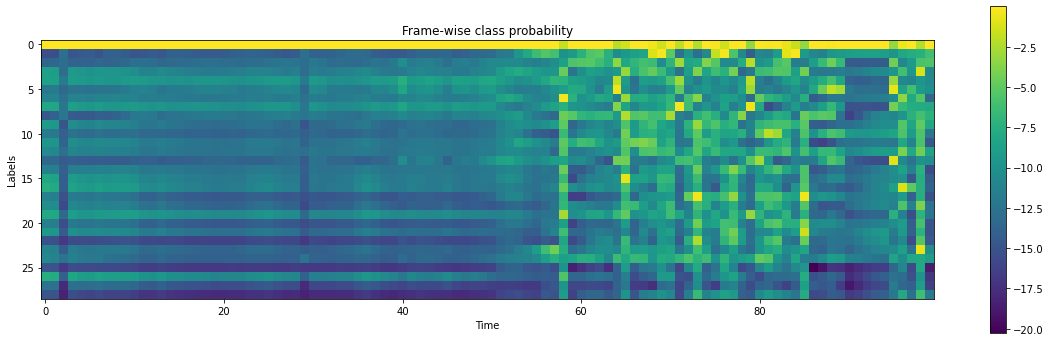

In [450]:
plt.rcParams["figure.figsize"] = (20,6)
print(labels)
plt.imshow(emission.T[:, :100])
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [451]:
# with open(SPEECH_FILE[:-4] + '.txt') as f:
#     transcript = f.read()
#     transcript = transcript.upper().replace(' ', '|')
transcript = transcript.upper().replace(' ', '|')
dictionary  = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t+1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

trellis = get_trellis(emission, tokens)

[('I', 6), ('F', 16), ('|', 0), ('I', 6), ('|', 0), ('F', 16), ('U', 12), ('C', 15), ('K', 22), ('|', 0), ('T', 2), ('H', 7), ('I', 6), ('S', 8), ('|', 0), ('M', 13), ('O', 4), ('D', 10), ('E', 1), ('L', 11), ('|', 0), ('A', 3), ('N', 5), ('D', 10), ('|', 0), ('S', 8), ('H', 7), ('E', 1), ('|', 0), ('J', 25), ('U', 12), ('S', 8), ('T', 2), ('|', 0), ('B', 20), ('L', 11), ('E', 1), ('A', 3), ('C', 15), ('H', 7), ('E', 1), ('D', 10), ('|', 0), ('H', 7), ('E', 1), ('R', 9), ('|', 0), ('A', 3), ('S', 8), ('S', 8), ('H', 7), ('O', 4), ('L', 11), ('E', 1)]


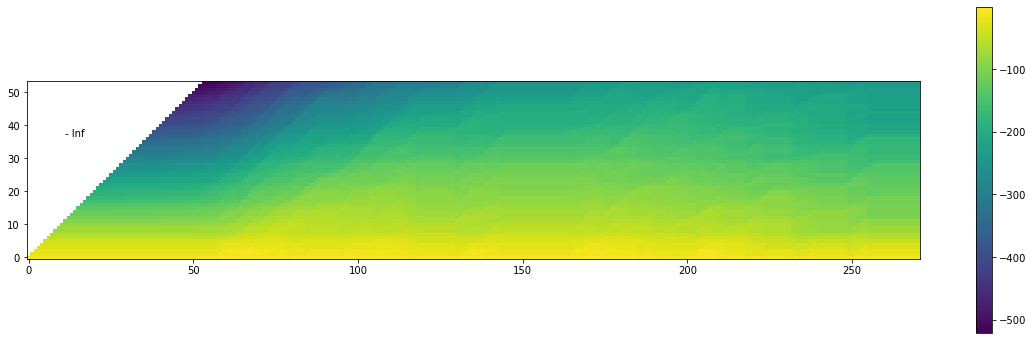

In [452]:
plt.imshow(trellis[1:, 1:].T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [453]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When refering to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when refering to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t-1, j] + emission[t-1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j-1, t-1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    return path[::-1]

path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=58, score=0.6943073868751526), Point(token_index=1, time_index=59, score=3.330916297272779e-05), Point(token_index=2, time_index=60, score=0.9905063509941101), Point(token_index=2, time_index=61, score=0.9867402911186218), Point(token_index=3, time_index=62, score=0.00037726573646068573), Point(token_index=4, time_index=63, score=0.9967674016952515), Point(token_index=4, time_index=64, score=0.12583230435848236), Point(token_index=5, time_index=65, score=0.003153506899252534), Point(token_index=5, time_index=66, score=0.9754602313041687), Point(token_index=5, time_index=67, score=0.9594904184341431), Point(token_index=6, time_index=68, score=0.0042481860145926476), Point(token_index=7, time_index=69, score=0.0012737741926684976), Point(token_index=7, time_index=70, score=0.9102799892425537), Point(token_index=7, time_index=71, score=0.1430201381444931), Point(token_index=7, time_index=72, score=0.9790003895759583), Point(token_index=8, time_index=73, sc

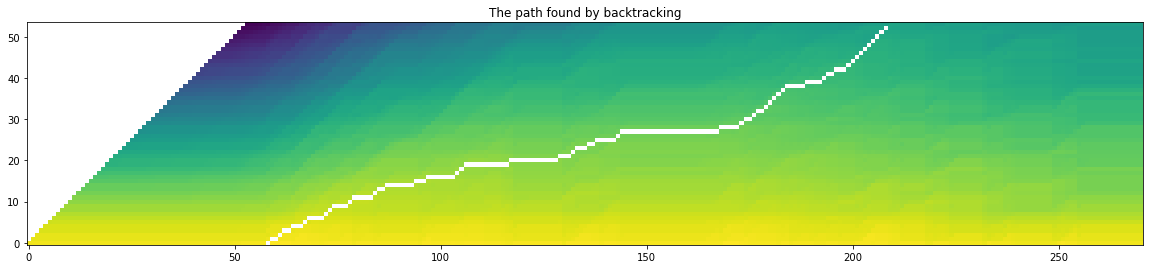

In [454]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float('nan')
    plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [455]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start

def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
        i1 = i2
    return segments

segments = merge_repeats(path)
for seg in segments:
    print(seg)

I	(0.69): [   58,    59)
F	(0.00): [   59,    60)
|	(0.99): [   60,    62)
I	(0.00): [   62,    63)
|	(0.56): [   63,    65)
F	(0.65): [   65,    68)
U	(0.00): [   68,    69)
C	(0.51): [   69,    73)
K	(0.08): [   73,    74)
|	(0.97): [   74,    75)
T	(0.52): [   75,    79)
H	(0.60): [   79,    80)
I	(0.49): [   80,    85)
S	(0.01): [   85,    86)
|	(0.99): [   86,    88)
M	(0.85): [   88,    95)
O	(0.55): [   95,    98)
D	(0.76): [   98,   105)
E	(0.56): [  105,   106)
L	(0.02): [  106,   107)
|	(0.65): [  107,   118)
A	(0.91): [  118,   130)
N	(0.70): [  130,   133)
D	(0.09): [  133,   134)
|	(0.90): [  134,   137)
S	(0.49): [  137,   139)
H	(0.63): [  139,   144)
E	(0.89): [  144,   145)
|	(0.97): [  145,   169)
J	(0.61): [  169,   174)
U	(0.00): [  174,   175)
S	(0.77): [  175,   177)
T	(0.86): [  177,   178)
|	(0.83): [  178,   180)
B	(0.00): [  180,   181)
L	(0.03): [  181,   182)
E	(0.83): [  182,   183)
A	(0.01): [  183,   184)
C	(0.00): [  184,   185)
H	(0.44): [  185,   190)


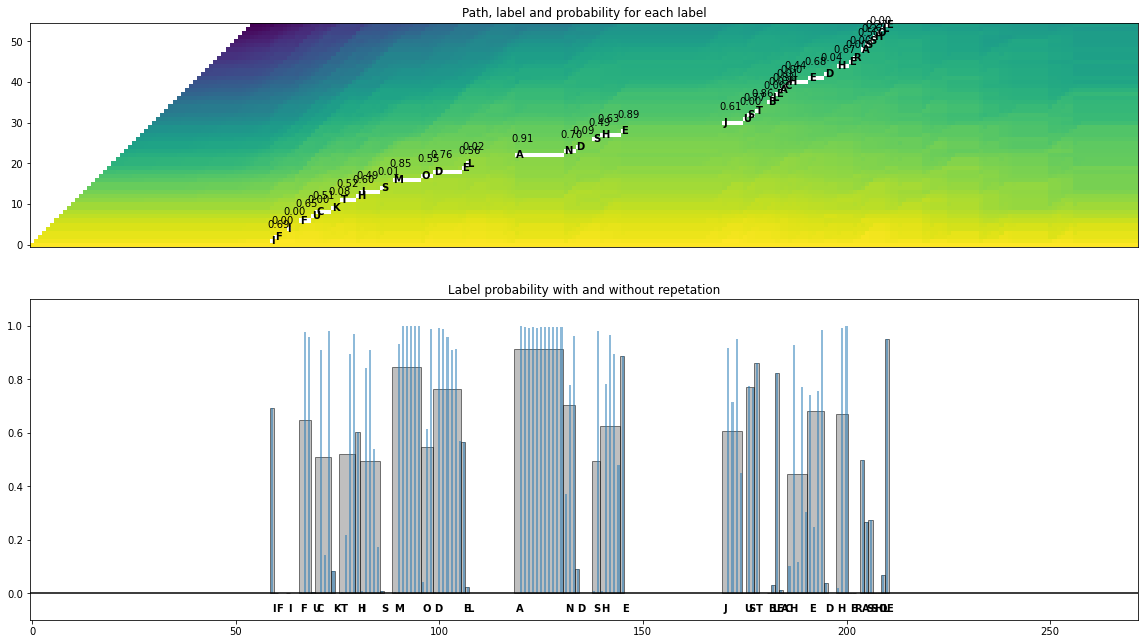

In [457]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != '|':
            trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin='lower')
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != '|':
            ax1.annotate(seg.label, (seg.start + .7, i + 0.3), weight='bold')
            ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != '|':
            xs.append((seg.end + seg.start) / 2 + .4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + .8, -0.07), weight='bold')
    ax2.bar(xs, hs, width=ws, color='gray', alpha=0.5, edgecolor='black')

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != '|':
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color='black')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [458]:
# Merge words
def merge_words(segments, separator='|'):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = ''.join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words

word_segments = merge_words(segments)
for word in word_segments:
    print(word)

IF	(0.35): [   58,    60)
I	(0.00): [   62,    63)
FUCK	(0.45): [   65,    74)
THIS	(0.47): [   75,    86)
MODEL	(0.71): [   88,   107)
AND	(0.82): [  118,   134)
SHE	(0.62): [  137,   145)
JUST	(0.60): [  169,   178)
BLEACHED	(0.39): [  180,   195)
HER	(0.40): [  197,   202)
ASSHOLE	(0.29): [  203,   210)


In [459]:
trellis.size()

torch.Size([272, 55])

In [460]:
word_segments

[IF	(0.35): [   58,    60),
 I	(0.00): [   62,    63),
 FUCK	(0.45): [   65,    74),
 THIS	(0.47): [   75,    86),
 MODEL	(0.71): [   88,   107),
 AND	(0.82): [  118,   134),
 SHE	(0.62): [  137,   145),
 JUST	(0.60): [  169,   178),
 BLEACHED	(0.39): [  180,   195),
 HER	(0.40): [  197,   202),
 ASSHOLE	(0.29): [  203,   210)]

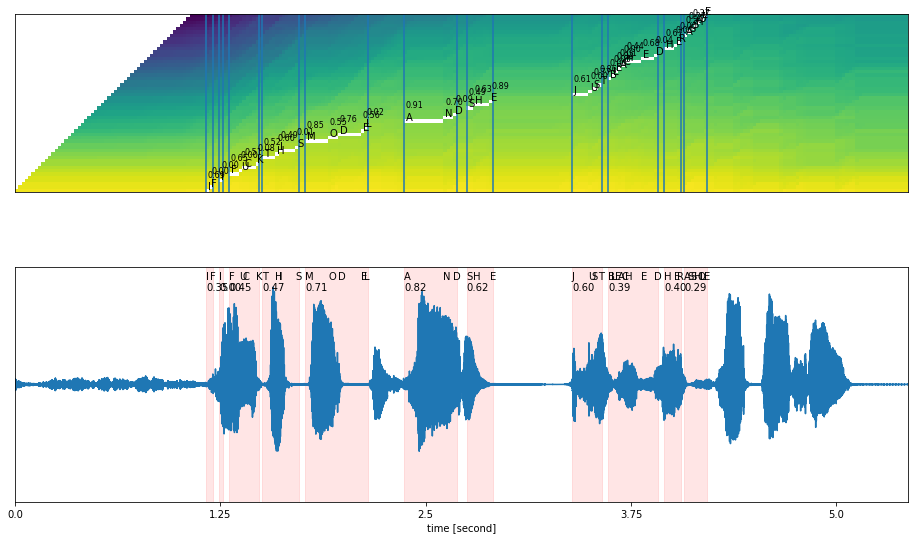

In [470]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != '|':
            trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != '|':
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color='red')
        ax2.annotate(f'{word.score:.2f}', (x0, 0.8))

    for seg in segments:
        if seg.label != '|':
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / sr)
    ax2.set_xlabel('time [second]')
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))

plot_alignments(trellis, segments, word_segments, waveform)
plt.show()

# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    filename = f"_assets/{i}_{word.label}.wav"
#     torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
    print(f"{word.label} ({word.score:.2f}): {x0 / sr:.3f} - {x1 / sr:.3f} sec")
    return IPython.display.Audio(data=waveform[x0:x1], rate=sr)


# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segments(shift=0, phrase_len=-1):
#     ratio = 1
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    x0 = int(ratio * word_segments[shift].start)
    x1 = int(ratio * word_segments[shift + phrase_len - 1].end)
    print(f"{' '.join([word.label for word in word_segments[shift:shift + phrase_len]])}: {x0 / sr:.3f} - {x1 / sr:.3f} sec")
    return IPython.display.Audio(waveform[x0:x1], rate=sr)


In [462]:
word_segments

[IF	(0.35): [   58,    60),
 I	(0.00): [   62,    63),
 FUCK	(0.45): [   65,    74),
 THIS	(0.47): [   75,    86),
 MODEL	(0.71): [   88,   107),
 AND	(0.82): [  118,   134),
 SHE	(0.62): [  137,   145),
 JUST	(0.60): [  169,   178),
 BLEACHED	(0.39): [  180,   195),
 HER	(0.40): [  197,   202),
 ASSHOLE	(0.29): [  203,   210)]

In [463]:
IPython.display.display(IPython.display.Audio(waveform, rate=sr))

In [466]:
word_segments[10]

ASSHOLE	(0.29): [  203,   210)

In [355]:
waveform[3*sr: 4:sr]

tensor([])

In [473]:
display_segments(2, 1)

FUCK: 1.304 - 1.485 sec


In [472]:
display_segments(9, 2)

HER ASSHOLE: 3.952 - 4.213 sec


In [390]:
display_segments(15, 3)

ON MY T: 4.051 - 4.692 sec


In [303]:
! cp /d0/mir/explicit/separated/mdx_extra_q/wuO4_P_8p-Q/no_vocals.wav ./